In [9]:
!pip install imbalanced-learn

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   region_id                 6000 non-null   object 
 1   month                     6000 non-null   object 
 2   gini_index                6000 non-null   float64
 3   unemployment_rate         6000 non-null   float64
 4   inflation_rate            6000 non-null   float64
 5   media_sentiment_index     6000 non-null   float64
 6   rainfall_deviation        6000 non-null   float64
 7   policy_instability_index  6000 non-null   int64  
 8   prior_unrest_count        6000 non-null   float64
 9   population_density        6000 non-null   float64
 10  food_price_index          6000 non-null   float64
 11  fuel_subsidy_cut          6000 non-null   int64  
 12  gov_approval              6000 non-null   float64
 13  neighbor_unrest_prev      6000 non-null   int64  
 14  unrest_e

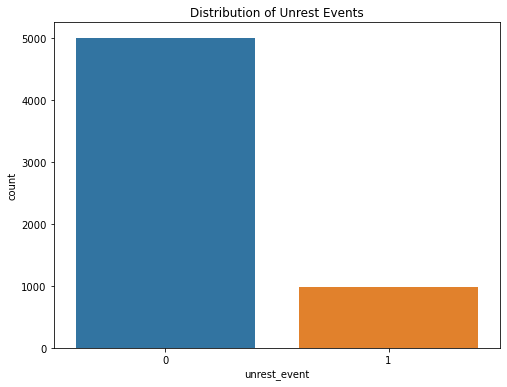

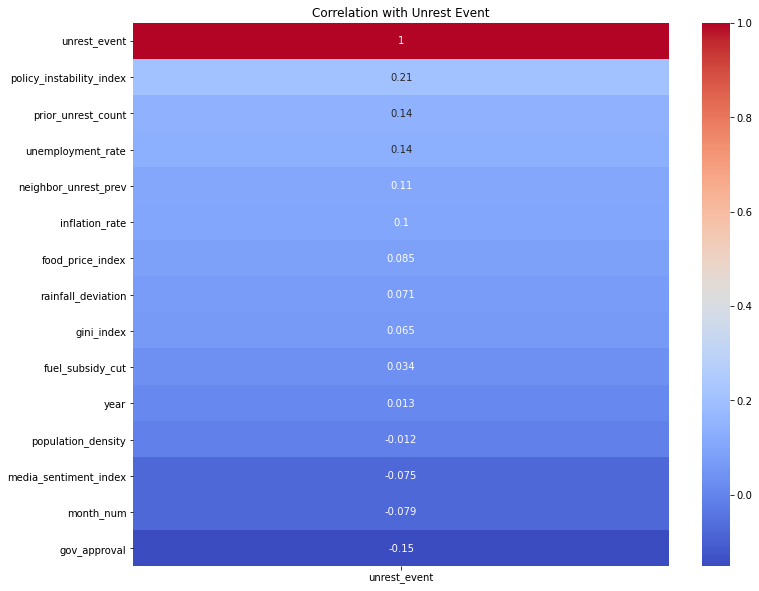

              precision    recall  f1-score   support

           0       0.87      0.71      0.78      1503
           1       0.24      0.47      0.32       297

    accuracy                           0.67      1800
   macro avg       0.56      0.59      0.55      1800
weighted avg       0.77      0.67      0.71      1800

ROC AUC: 0.6407006413659774
Average Precision: 0.2507507323370477


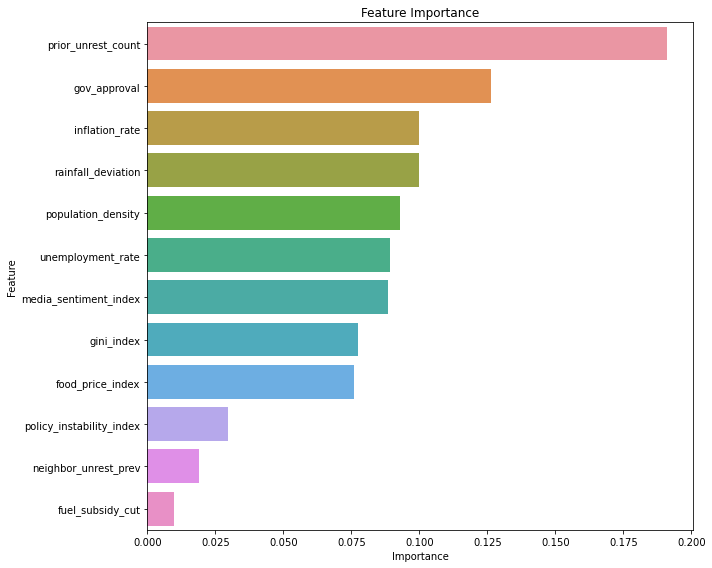

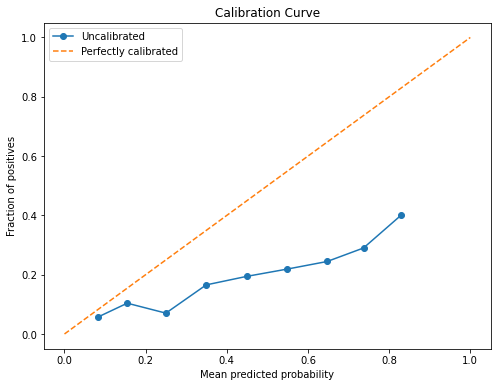

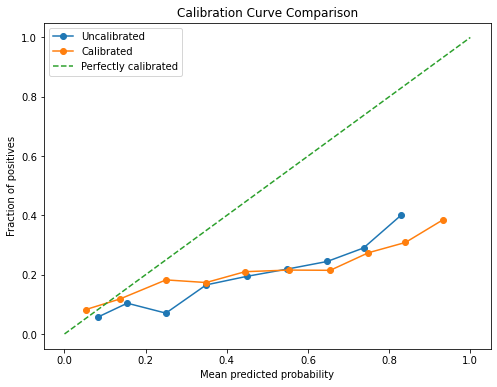

In [1]:

# # Societal Unrest Prediction Analysis

# ## Overview
# This analysis aims to build a predictive model for societal unrest using economic, environmental, and sociopolitical indicators across 50 regions over time. The goal is to forecast the probability of unrest one month in advance and identify the most influential indicators.

# ## Analysis Approach

### 1. Data Exploration and Preprocessing


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Load data
df = pd.read_csv('unrest.csv')

# Basic exploration
print(df.info())
print(df.describe())
print(df['unrest_event'].value_counts(normalize=True))

# Check for missing values
print(df.isnull().sum())

# Handle missing values (if any)
df = df.dropna()

# Feature engineering
df['month'] = pd.to_datetime(df['month'])
df['year'] = df['month'].dt.year
df['month_num'] = df['month'].dt.month

# Visualize target distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='unrest_event', data=df)
plt.title('Distribution of Unrest Events')
plt.show()

# Correlation analysis
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix[['unrest_event']].sort_values(by='unrest_event', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title('Correlation with Unrest Event')
plt.show()

### 2. Model Building


# Prepare features and target
X = df.drop(['region_id', 'month', 'unrest_event', 'year', 'month_num'], axis=1)
y = df['unrest_event']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


from imblearn.over_sampling import SMOTE

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Build pipeline with scaling and classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42
    ))
])

# Train model
pipeline.fit(X_train_smote, y_train_smote)

# Predict probabilities
y_probs = pipeline.predict_proba(X_test)[:, 1]
y_pred = pipeline.predict(X_test)

# Evaluate model
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_probs)}")
print(f"Average Precision: {average_precision_score(y_test, y_probs)}")

# Feature importance
importances = pipeline.named_steps['classifier'].feature_importances_
features = X.columns
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

### 3. Model Calibration

# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Uncalibrated')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

# Calibrate model
calibrated = CalibratedClassifierCV(pipeline.named_steps['classifier'], method='isotonic', cv=5)
calibrated.fit(X_train_smote, y_train_smote)
y_probs_calibrated = calibrated.predict_proba(X_test)[:, 1]

# Re-evaluate calibrated model
prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_probs_calibrated, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Uncalibrated')
plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve Comparison')
plt.legend()
plt.show()
